#### Loading files and metadata

In [1]:
suppressPackageStartupMessages(library(sva))
suppressPackageStartupMessages(library(TreeSummarizedExperiment))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))

In [2]:
metaData <- read.delim("/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/SYNAPSE_METADATA_MANIFEST.tsv")
quantDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/sal_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
tissuesOfInt <- c("cerebellum", "medial dorsal nucleus of thalamus")
saveDir <- "../environment/chimpBrain"
metaData <- metaData %>% 
    filter(tissue %in% tissuesOfInt)
dim(metaData)[1] == 10
samples <- sapply(strsplit(metaData[["path"]],"/", fixed = T), function(x) 
        sapply(strsplit(x[[length(x)]], ".", fixed = T), function(x) x[1]))
files <- file.path(quantDir, samples, "quant.sf")
all(file.exists(files))
colData <- data.frame(files = files, names = samples, tissue = as.factor(metaData[["tissue"]]))
clustFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100//nothr0//cluster_nwk.txt"
               
#### Add gene annotation, since that could not be found by tximeta
indDir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/refseq_ind/sal_ind/"
fastaPath <- c("/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/refseq_ind/Pan_troglodytes.Pan_tro_3.0.cdna.all.fa.gz",
           "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/refseq_ind/Pan_troglodytes.Pan_tro_3.0.ncrna.fa.gz")
gtfPath <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/refseq_ind/Pan_troglodytes.Pan_tro_3.0.104.gtf.gz"
tximeta::makeLinkedTxome(indexDir=indDir, source="ensembl", organism="Pan Troglodytes",
                release="104", genome="panTro3", fasta=fastaPath, gtf=gtfPath, write=T)
seChimp <- tximeta::tximeta(colData)
               
tseChimp <- beaveR::buildTSE(treeTermFile = clustFile, coldata = colData)
               
tree <- rowTree(tseChimp)
l <- length(tree$tip)
               
tseChimp <- fishpond::computeInfRV(tseChimp)

[1] TRUE

[1] TRUE

NOTE: linkedTxome with source='Ensembl', ensembldb will be used to parse GTF.
this may produce errors if the GTF is not from Ensembl, or has been modified.
set useHub=FALSE in tximeta to avoid download of reference txome from AnnotationHub.
alternatively use a different string for source argument

writing linkedTxome to /fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/refseq_ind/sal_ind/.json

linkedTxome is same as already in bfc

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 


found matching linked transcriptome:
[ Ensembl - Pan Troglodytes - release 104 ]

loading existing EnsDb created: 2023-05-07 17:27:02

loading existing transcript ranges created: 2023-12-24 19:02:11

reading tree

importing quantifications

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 


found matching linked transcriptome:
[ Ensembl - Pan Troglodytes - release 104 ]

loading existing EnsDb created: 2023-05-07 17:27:02

loading existing transcrip

#### PCA on normalized counts
We see batch effects

using counts and average transcript lengths from tximeta

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size



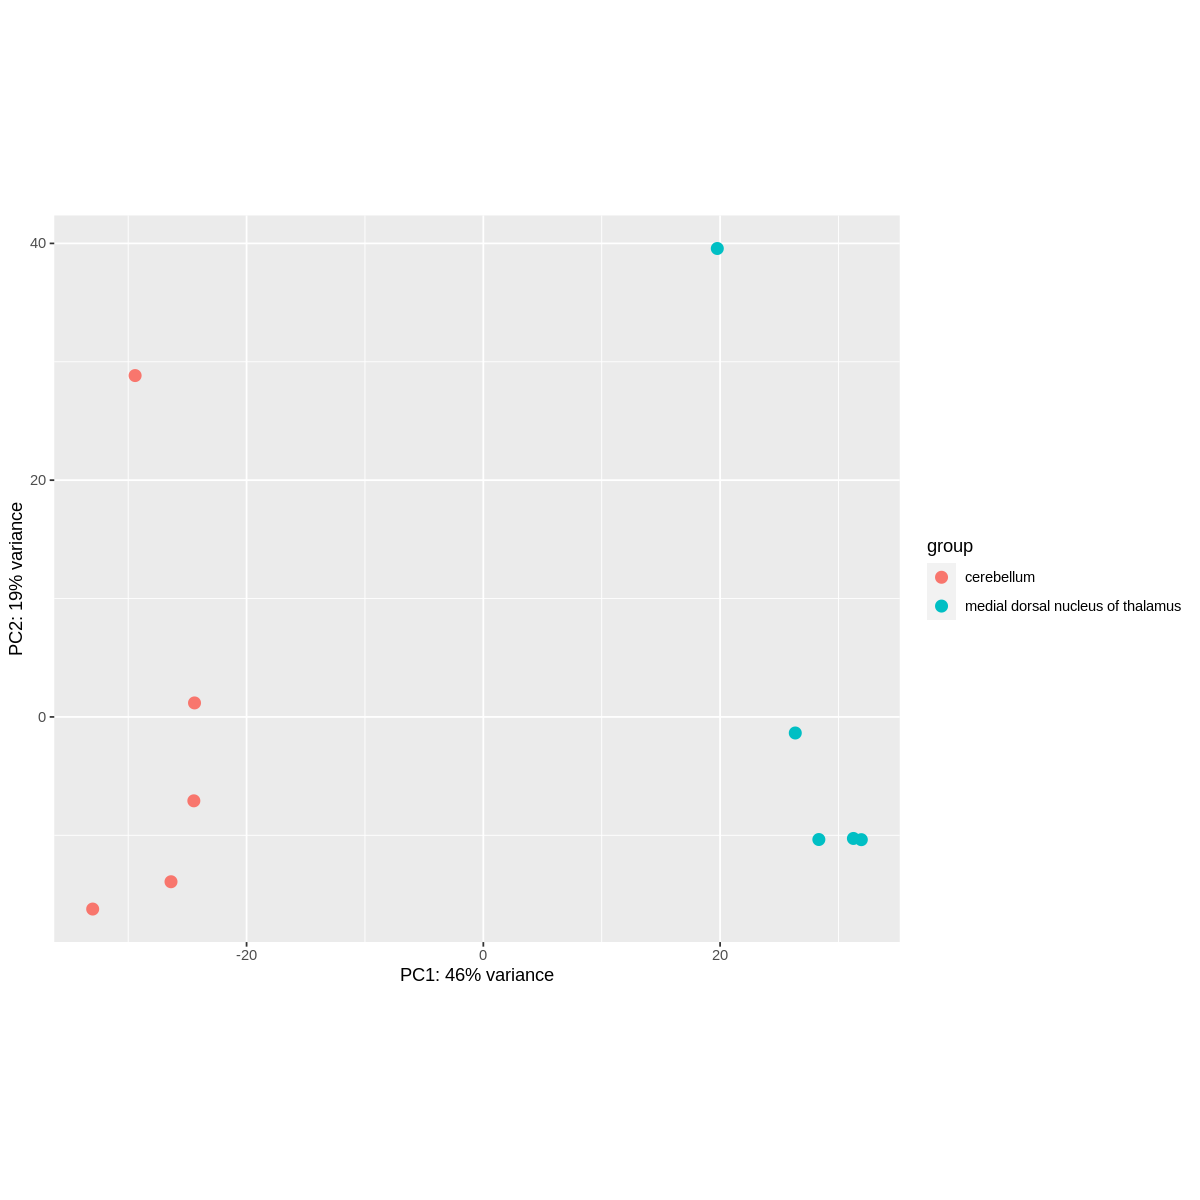

In [15]:
dds <- DESeq2::DESeqDataSet(tseChimp[1:l,], design=~tissue)
dds <- DESeq2::estimateSizeFactors(dds)
dds <- dds[rowSums(assays(dds)[["counts"]]) > 10,]
vsd <- DESeq2::vst(dds)
DESeq2::plotPCA(vsd, intgroup=c("tissue"), ntop=1000)

#### Correcting batch effects n=2

In [9]:
y <- fishpond::scaleInfReps(tseChimp[1:l,])
infRepIdx <- grep("infRep",assayNames(y),value=TRUE)
nreps <- length(infRepIdx)

mm <- model.matrix(~tissue, colData(dds))
mm0 <- model.matrix(~ 1, colData(dds))
norm.cts <- counts(dds, normalized=TRUE)
norm.cts <- norm.cts[rowSums(norm.cts) > 0,]

In [ ]:
fit <- svaseq(norm.cts, mod=mm, mod0=mm0, n.sv=4)
for (k in seq_len(nreps)) {
    logInfRep <- log(assay(y, infRepIdx[k]) + 0.1)
    logInfRep <- limma::removeBatchEffect(
      logInfRep,
      covariates=fit[["sv"]],
      design=mm)
    assay(y, infRepIdx[k]) <- exp(logInfRep)
}

In [ ]:
top <- order(matrixStats::rowVars(assays(y)[["infRep1"]]), decreasing = T)[1:1000]
pca <- prcomp(t(assays(y)[["infRep1"]][top,]), scale = T)
        
scores <- data.frame(pca$x[,1:2], group = factor(rep(c("cerebellum", "medial dorsal"), each = 5)),
            var = pca$sdev^2/sum(pca$sdev^2))

print(scores[["var"]])
print(ggplot(scores, aes(x = PC1, y = PC2, color = group)) +
  geom_point() +
  xlab("PC1") +
  ylab("PC2") +
  ggtitle("PCA Plot with Grouping"))

In [5]:
y <- fishpond::labelKeep(y)
set.seed(10)
y <- fishpond::swish(y, x="tissue")
save(y, file=file.path(saveDir, "y.RData"))

### Batch effects on the tree nodes

In [106]:
yAll <- beaveR::computeSizeFactors(tseChimp)
yAll <- beaveR::scInfReps(yAll)
mm <- model.matrix(~tissue, colData(dds))
mm0 <- model.matrix(~ 1, colData(dds))
norm.cts <- counts(dds, normalized=TRUE)
norm.cts <- norm.cts[rowSums(norm.cts) > 0,]

fit <- svaseq(norm.cts, mod=mm, mod0=mm0, n.sv=2)
pc <- .1

for (k in seq_len(nreps)) {
    logInfRep <- log(assay(yAll, infRepIdx[k]) + pc)
    logInfRep <- limma::removeBatchEffect(
      logInfRep,
      covariates=fit[["sv"]],
      design=mm)
    assay(yAll, infRepIdx[k]) <- exp(logInfRep)
}

#### Run Swish

In [105]:
yAll <- fishpond::labelKeep(yAll)
set.seed(10)
yLeaves <- fishpond::swish(yAll[1:nleaves,], x="tissue")
set.seed(10)
yInn <- fishpond::swish(yAll[(l+1):nrow(yAll),], x = "tissue")
mcols(yAll)[["pvalues"]] <- c(mcols(yLeaves)[["pvalues"]], mcols(yInn)[["pvalues"]])
save(yAll, file=file.path(saveDir, "yAll.RData"))

### Gene Level

In [13]:
gy <- tximeta::summarizeToGene(seChimp)
options(repr.plot.width=10, repr.plot.height=10)
dds <- DESeq2::DESeqDataSet(gy, design=~tissue)
dds <- DESeq2::estimateSizeFactors(dds)
dds <- dds[rowSums(assays(dds)[["counts"]]) > 10,]

loading existing EnsDb created: 2023-05-07 17:27:02

obtaining transcript-to-gene mapping from database

loading existing gene ranges created: 2023-05-07 17:27:18

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates

using counts and average transcript lengths from tximeta

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size



In [55]:
yg <- gy
yg <- fishpond::scaleInfReps(yg)

infRepIdx <- grep("infRep",assayNames(gy),value=TRUE)
nreps <- length(infRepIdx)

mm <- model.matrix(~tissue, colData(dds))
mm0 <- model.matrix(~ 1, colData(dds))
norm.cts <- counts(dds, normalized=TRUE)
norm.cts <- norm.cts[rowSums(norm.cts) > 0,]
     
fit <- svaseq(norm.cts, mod=mm, mod0=mm0, n.sv=2)
pc <- .1
for (k in seq_len(nreps)) {
    logInfRep <- log(assay(yg, infRepIdx[k]) + pc)
    logInfRep <- limma::removeBatchEffect(
      logInfRep,
      covariates=fit[["sv"]],
      design=mm)
      assay(yg, infRepIdx[k]) <- exp(logInfRep)
}

using counts and average transcript lengths from tximeta

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size



Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [3]:
yg <- fishpond::labelKeep(yg)
set.seed(10)
yg <- fishpond::swish(yg, x="tissue")
save(yg, file=file.path(saveDir, "yg.RData"))

### Terminus

In [7]:
termFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old/PTB162LCBC/clusters.txt"
suppressPackageStartupMessages(source("../terminus_helper.R"))
yTermThrNS <- tseChimp[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS, gsub = TRUE)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepTerm(yTermThrNS, mInds, groupsClust)
yTerm <- yAggTermThrNS[-unlist(groupsClust),]
yTerm <- fishpond::scaleInfReps(yTerm)

using counts and average transcript lengths from tximeta

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

using 'avgTxLength' from assays(dds), correcting for library size



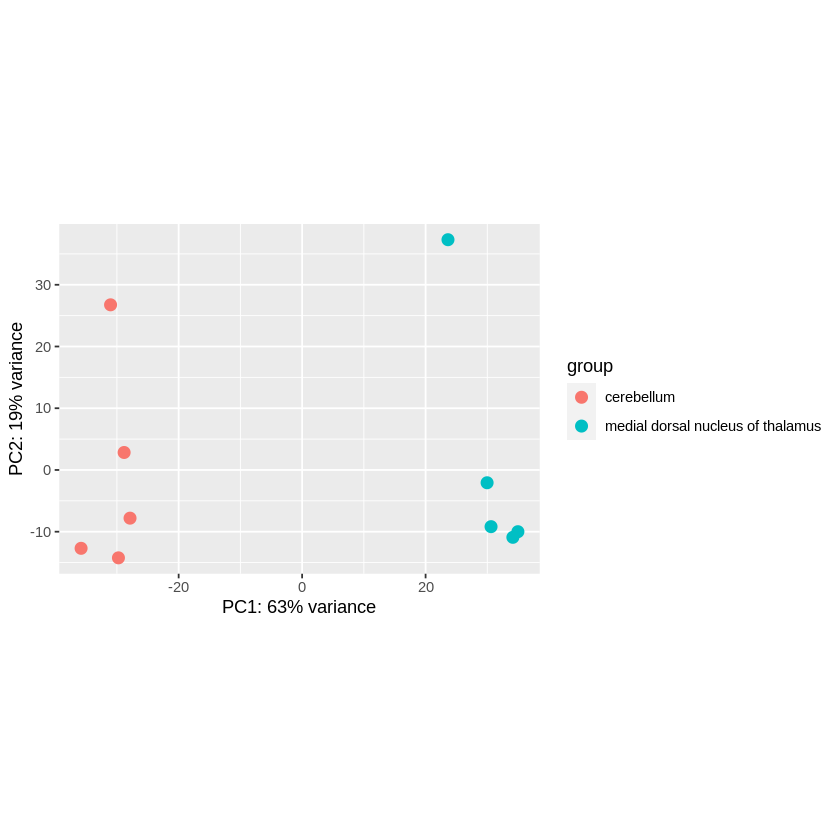

In [8]:
dds <- DESeq2::DESeqDataSet(yAggTermThrNS[-unlist(groupsClust),], design=~tissue)
dds <- DESeq2::estimateSizeFactors(dds)
dds <- dds[rowSums(assays(dds)[["counts"]]) > 10,]
vsd <- DESeq2::vst(dds)
DESeq2::plotPCA(vsd, intgroup=c("tissue"), ntop=1000)

In [10]:
infRepIdx <- grep("infRep",assayNames(yTerm),value=TRUE)
nreps <- length(infRepIdx)

mm <- model.matrix(~tissue, colData(dds))
mm0 <- model.matrix(~ 1, colData(dds))
norm.cts <- counts(dds, normalized=TRUE)
norm.cts <- norm.cts[rowSums(norm.cts) > 0,]
     
fit <- svaseq(norm.cts, mod=mm, mod0=mm0, n.sv=2)
pc <- .1
for (k in seq_len(nreps)) {
    logInfRep <- log(assay(yTerm, infRepIdx[k]) + pc)
    logInfRep <- limma::removeBatchEffect(
      logInfRep,
      covariates=fit[["sv"]],
      design=mm)
      assay(yTerm, infRepIdx[k]) <- exp(logInfRep)
}

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [12]:
yTerm <- fishpond::labelKeep(yTerm)
set.seed(10)
yTerm <- fishpond::swish(yTerm, x="tissue")

### Feature extraction

In [18]:
detNodes <- list()
negNodes <- list()

In [20]:
detNodes[["Txps"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))
detNodes[["Genes"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(yg)[,"qvalue"] <= x ))
detNodes[["Terminus"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]
        match(nodes, names(yAggTermThrNS))
})
negNodes[["Txps"]] <- lapply(detNodes[["Txps"]], function(nodes) setdiff(seq(l), nodes))
negNodes[["Genes"]] <- lapply(detNodes[["Genes"]], function(nodes) setdiff(seq(nrow(gy)), nodes))
negNodes[["Terminus"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[setdiff(seq(nrow(yTerm)),
                                                 which(mcols(yTerm)[,"qvalue"] <= x))]
        match(nodes, rownames(yAggTermThrNS))
    })                            

In [36]:
save(detNodes, file=file.path(saveDir, "detNodes.RData"))
save(negNodes, file=file.path(saveDir, "negNodes.RData"))